In [75]:
import os
import numpy as np
import sympy as s
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import pandas as pd
import scipy as sci
from IPython.display import Markdown, display, Math, HTML

# Inits
reload_Gifs = True

# Some tools:

def mirrorZ(complexCurve, mirrorAng, centerPt:complex = 0):
    if centerPt != 0:
        complexCurve = [cCurve - centerPt for cCurve in complexCurve]
    return [z * np.exp(-1j * (np.angle(z) - mirrorAng) * 2) + centerPt for z in complexCurve]

def rotateZ(complexCurve, ang, centerPt:complex = 0):
    return [(z - centerPt) * np.exp(1j*ang) + centerPt for z in complexCurve]

## Resources:

1) _Analytical Mechanics of Gears_, Earle Buckingham, Dover Publications. SBN 486-61073-X, Library of Congress 63-21681.

# Chapter 1: Conjugate Action Profiles

The basic principle behind all gears is a conjugate action between two profiles. That is, of teeth going in and out of mesh to transfer force and motion. 

The foundation of the analysis of curves that produce a desired conjugate action is to define a **Path of Contact** between the two curves; this will define the various points where the two curves touch during the meshing process. 

One can technically define the Contact Path directly, but more generally, it is the desire to generate the mating gear to a known existing profile. One method of doing this is to define a Cartesian equation $x = f(y)$ for the driving tooth profile. Generally this is provided in terms of the rack-form of the gear tooth. It is simpler to work with than the gear form (where the rack is stretched over a circle). 

For the tooth curves to interact without unwanted interference, then the tangent of each point must be continuous and equal to the equivalent tangent on the mating curve. This can be expressed equally that the **pressure angle** -- the angle defining the line perpendicular $^1$ to the tooth curves, as measured from the rack length or the tangent of the two pitch circles. This perpendicular line is the **'line of action'**.

Mathematically, the pressure angle $\phi$ is defined as $tan(\phi) = \frac{dx}{dy}$.

Generally speaking, you have a roughly known range of heights (rack) or range of radiuses (gear) over which you expect the operation; for this analysis, the relative height (that is, distance from the mean) is normalized to $y = \pm 1$. The mean height of the curves is described as the **pitch line** (for a rack) or **pitch circle** (for a gear), and the origin ($x = 0$, $y=0$) is known as the **pitch point**. The pitch point is, physically, the 'symmetry' point of the two gears, where the contact of the tooth curves is coincident with a line running between each gears' centerpoint.

Looked at a different way (one might say in a _constructive_ mindset, rather than _applications_), the pitch circle/line is the fundamental starting point of the teeth geometry. It is the point in which the interaction of the teeth begins and moves in and out of. This is in the sense that the contact point between the teeth will climb one tooth (as it descends the other), then end as the teeth come out of engagement and another tooth pair goes into engagement, starting at the opposite end, climbing again until it reaches the pitch point, restarting the cycle; hence the symmetry described earlier. 

For most gear teeth curves, the pitch point is a unique point, and describes the only functional line/radius that will allow for properly meshing teeth $ ^2$. This is important as the pitch radius also defines the effective rotational radius of the gear -- the gear ratio. As example, a gear of pitch radius 2 will rotate half as quickly as the mating gear of radius 1. 

$ ^1$ Or in 3-D, normal.

$ ^2$ The important *involute profile* in general is not limited by this, in that the pitch line/radius can be changed between two different gears while still allowing for proper meshing. That said, the pitch point is still fundamental to the design of any particular pairs of mating involute gear teeth being used.

## Implementation: Rack Tooth Defined
Using a basis of a defined rack tooth (likely to be the cutter geometry) to develop the contact path and the associated gear teeth.

_A preface: the below gifs have the rotational/translational speeds defined by the transmission ratio of the diameters, for simplicity. However, for profiles other than cycloidal/involute, this is not physically accurate; the engagement point moves at different rates on either side of the gearset, making the conjugate action velocity nonlinear._

The idea of generating a mating tooth form is actually relatively simple:

* Take your original tooth form
* Determine the path of contact
* Translate that over to the mating gear. 

The path of contact itself is found as the associated change in height of along the original tooth curve as it moves left to right (rack) or rotates CW/CCW (gear). 

Beginning with a simple arc profile:

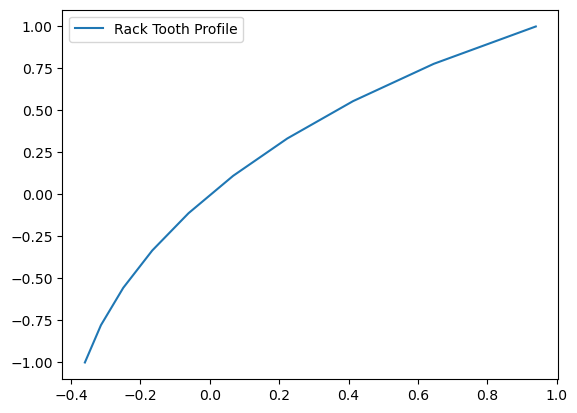

In [76]:
x, y, xp, phi = s.symbols("x y x_p \\phi ")

Eqs = {}
Eqs["curveFunc"] = (3*np.cos(np.pi/6) - x)**2 + (y + 3*np.sin(np.pi/6))**2 - 3**2 # = 0
Eqs[x] = s.solve(Eqs["curveFunc"], x)[0]
plt.plot([Eqs[x].subs({y:ypt}) for ypt in np.linspace(-1,1,10)], np.linspace(-1,1,10), label = "Rack Tooth Profile")
plt.legend()

This can then be translated into a set of points on the contact path by that understanding of the change in pressure angle across the curve: 

$tan(\phi) = \frac{dx}{dy}$

Accordingly, for some arbitrarily small incremental change of x and y (moving from the original point to a new point on the contact path subscript *p*), the approximation holds

$\frac{x_p}{y_p} = \frac{dx}{dy}$

Rewriting this, making it negative (for sake of making it 'left handed', by preference), and noting that for a rack profile the y will be the same across any translations:

$x_p = \frac{-y}{tan(\phi)} = \frac{-y}{ dx / dy }$

In [77]:
Eqs["tphi"] = s.diff(Eqs[x], y)
display(Eqs[x], Eqs['tphi'])

2.59807621135331 - 2.59807621135331*sqrt(-0.148148148148148*y**2 - 0.444444444444444*y + 1)

-2.59807621135331*(-0.148148148148148*y - 0.222222222222222)/sqrt(-0.148148148148148*y**2 - 0.444444444444444*y + 1)

In [78]:
Eqs[xp] = -1 * y / Eqs['tphi']

ys = np.linspace(-1,1,20)
contact = [Eqs[xp].subs({y:ypt}) for ypt in ys]
curve = [complex(Eqs[x].subs({y:ypt}), ypt) for ypt in ys]
translation = [curve[i].real - contact[i] for i in range(len(ys))]

fig, ax = plt.subplots()
ContactPath = ax.plot(contact, ys, 'orange', label="Path of Contact")[0]
ContactPathPt = ax.plot(contact[0], ys[0], 'ro')[0]
Tooth = ax.plot(np.real(curve) - translation[0], np.imag(curve), 'black', label = "Rack Tooth")[0]

frames = len(ys)
def update(frame):
    ContactPathPt.set_xdata([contact[frame]])
    ContactPathPt.set_ydata([ys[frame]])
    Tooth.set_xdata(np.real(curve) - translation[frame])
    Tooth.set_ydata(np.imag(curve))
    return (ContactPath, ContactPathPt, Tooth)

ax.set_xlim(-1.1 * float(max(contact)), 1.1 * float(max(contact)))
ax.set_aspect('equal')
ani = anim.FuncAnimation(fig = fig, func = update, frames = frames, interval = 5)
ax.legend(bbox_to_anchor=(1, 1),
          bbox_transform=fig.transFigure)
if reload_Gifs:
    ani.save("assets/RackSliding.gif", writer = 'pillow')
plt.close()
HTML('<img src="./assets/RackSliding.gif">')

### Finding the Mating Profile

To do the next steps requires some geometry.

For this, the values $r$, $\epsilon$, and $\theta$ are defined, all relative to the circular center of the desired mating gear. $r$ and $\theta$ define the polar coordinate point on the __mating tooth curve__ for any input point on the cartesian __original tooth curve__ $(x, y)$, as located when both gears are at the original pitch point orientation. 
To find this curve requires evaluating the contact point of the two curves at some amount of translation of the rack form -- that $x_p$ defined previously -- and then rotating it back to the desired pitch point orientation. The angular offset from the contact point interaction (the 'current rotation') back to the pitch point orientation (the 'original rotation') is $\epsilon$.

The formulas for each quantity are 

$r = \sqrt{x_p^2 + (R - y)^2}$ for Pitch Radius of the Mating Gear $R$

This is simply the result of the pythagorean triangle formed by the pitch radius line and the offsets to the $(x,y)$ from that motion to $x_p$.

$\epsilon = \frac{x_p - x}{R}$

Epsilon is a bit more complicated; it is finding the arc going from the original tooth curve in the origin orientation $x$ to the new $x$ value at the translated point $x_p$, and turning it back into a radian angle measure by dividing by $R$. The subtraction is due to that left-handedness of $x_p$ as it has been defined -- since $x_p$ is negative, it is really just summing their absolute values. This epsilon itself will need to be made negative for plotting (to make it a clockwise rotation). 

Notice that the $x$ and $x_p$ are originally defined as linear measure, not arcs -- strange then that they become radians when divided by the radius? This is the case because of our use of a rack-form -- they could be stretched over a circle to make a gear, and accordingly $x$ and $x_p$ would then become arcs. Since the motion of the gear is directly tied into the motion of the rack by conjugate action, these two values are effectively being wrapped about the mating gear during the meshing, *making* them arc measures.

$\theta = arctan( \frac{x_p}{R - y}) - \epsilon = arctan( \frac{x_p}{R - y}) - \frac{x_p - x}{R}$

This angle $\frac{x_p}{R - y}$ can be interpretted the same as $\epsilon$ is. It is the angle offset of contact point coordinate $(x_p, y)$ -- and since $\epsilon$ is the offset from this point to the desired original orientation, subtracting out $\epsilon$ will give the angle to this desired oriented point.

In [79]:
eps, theta, r, R = s.symbols("\\epsilon \\theta r R")
Eqs[r] = s.sqrt( (R - y)**2 + xp**2 )
Eqs[eps] = (xp - x)/R
Eqs[theta] = s.atan(xp / (R - y)) - Eqs[eps]

display(s.Eq(r, Eqs[r]))
display(s.Eq(eps, Eqs[eps]))
display(s.Eq(theta, Eqs[theta]))

Eq(r, sqrt(x_p**2 + (R - y)**2))

Eq(\epsilon, (-x + x_p)/R)

Eq(\theta, atan(x_p/(R - y)) - (-x + x_p)/R)

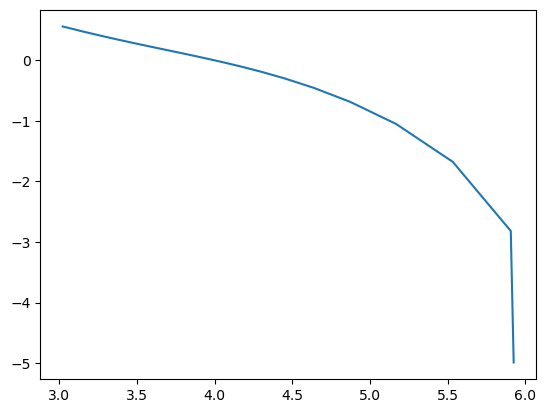

In [80]:
# Finding the profile for the mating gear of the rack profile
#   "Gear 2"
res = 20
Radius2 = 4
# d = Gear Data
d = {}
d['y'] = np.linspace(-1, 1, 20)
d['x'] = [Eqs[x].subs({y:ys}) for ys in d['y']]

for var in ['x_p', 'r', 'eps', 'theta']:
    d[var] = np.zeros(len(d['y']))

for i in range(len(d['y'])):
    vals = {y:d['y'][i], x:d['x'][i], R: Radius2}
    d["x_p"][i], vals[xp] = (Eqs[xp].subs(vals), )*2
    d["r"][i], vals[r] = (Eqs[r].subs(vals), )*2
    d["eps"][i], vals[eps] = (Eqs[eps].subs(vals), )*2
    d["theta"][i], vals[theta] = (Eqs[theta].subs(vals), )*2

data_Gear2 = pd.DataFrame(d)
data_Gear2['z'] = data_Gear2['r'] * np.exp(1j * data_Gear2['theta'])

fig, ax = plt.subplots()
ax.plot(np.real(data_Gear2['z']), np.imag(data_Gear2['z']))
plt.show()

Notice  that this profile could never function as a gear tooth due to this reversal on the right side; this is commonly called a 'cusp' in the profile. 

In this case, it is *in part* due to the defining path curve beginning to curve back on itself; adjusting the range of the curve should address some of this. There is additional constraint due to the particular radius of the Mating gear that may cause cusps as well.

This will be more of a problem when beginning to develop full gear sets, and making sure that both sides of the gearset are capable of properly meshing (based on number of teeth and relative radial size). It will be re-approached later; for now it will be bypassed by adjusting the mating gear radius.

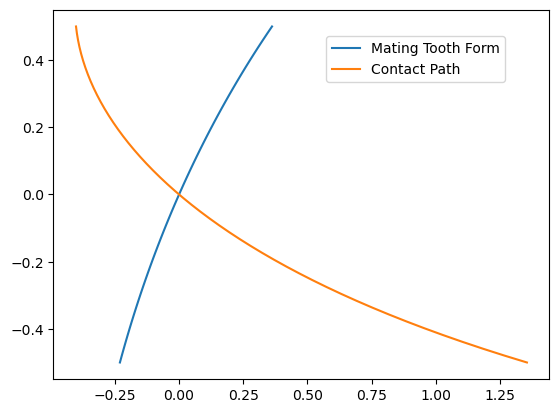

In [81]:
Radius2 = 4
ylim = .5

res = 50 # resolution

Eqs[x] = s.solve(Eqs["curveFunc"], x)[0]
Eqs["tphi"] = s.diff(Eqs[x], y)
Eqs[xp] = -1 * y / s.tan(Eqs['tphi'])

# d = Gear Data
d = {}
d['y'] = list(np.linspace(-ylim, ylim, res))
d['x'] = [Eqs[x].subs({y:ys}) for ys in d['y']]
d["x_p"] = [Eqs[xp].subs({y:coord[0], x:coord[1]}) for coord in [ [d['y'][i], d['x'][i]] for i in range(len(d['y']))] ]

plt.plot(d['x'], d['y'], label = "Mating Tooth Form")
plt.plot(d["x_p"], d['y'], label = "Contact Path")
plt.legend(bbox_to_anchor=(.8, .8),
          bbox_transform=fig.transFigure)


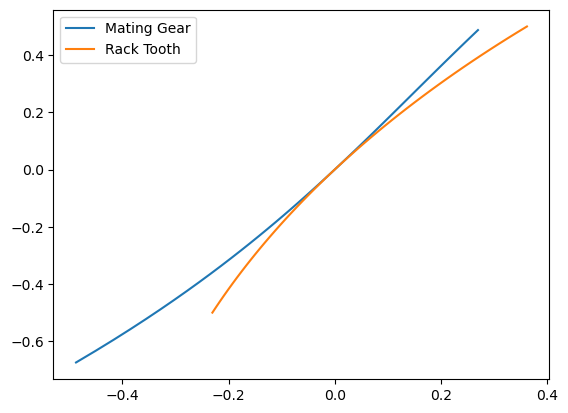

In [82]:
for var in ['r', 'eps', 'theta']:
    d[var] = np.zeros(len(d['y']))

for i in range(len(d['y'])):
    vals = {y:d['y'][i], x:d['x'][i], xp:d['x_p'][i], R: Radius2}
    d["r"][i], vals[r] = (Eqs[r].subs(vals), )*2
    d["eps"][i], vals[eps] = (Eqs[eps].subs(vals), )*2
    d["theta"][i], vals[theta] = (Eqs[theta].subs(vals), )*2

data_Gear2 = pd.DataFrame(d)
# Note that by the definition of everything, the mating gear must be oriented in a specific way
#   Hence the adjustments given -- rotating to be 'upright' rather than horizontal
data_Gear2['z'] = data_Gear2['r'] * np.exp(1j * data_Gear2['theta'] +1j*np.pi*3/2) + Radius2*1j

fig, ax = plt.subplots()
ax.plot(np.real(data_Gear2['z']), np.imag(data_Gear2['z']), label = "Mating Gear")
ax.plot(data_Gear2['x'], data_Gear2['y'], label = "Rack Tooth")
ax.legend()

In [83]:
fig, ax = plt.subplots()

MatingGear = lambda frame: rotateZ(data_Gear2['z'], data_Gear2['eps'][frame], Radius2*1j)
MatingGear_plt = ax.plot(np.real(MatingGear(0)), np.imag(MatingGear(0)), label = "Mating Gear")[0]

Rack = lambda frame: [complex(data_Gear2['x'][i] + (data_Gear2['x_p'][frame] - data_Gear2['x'][frame]),  data_Gear2['y'][i]) for i in range(res) ]
Rack_plt = ax.plot(np.real(Rack(0)), np.imag(Rack(0)), label = "Rack Tooth")[0]

ContactPt = lambda frame: complex(data_Gear2['x_p'][frame], data_Gear2['y'][frame])
ContactPt_plt = ax.plot(np.real(ContactPt(0)), np.imag(ContactPt(0)), 'ro', label = "Contact Point")[0]

Contact_plt = ax.plot(data_Gear2['x_p'], data_Gear2['y'], label = "Contact Path")

frames = res
def update(frame):
    MatingGear_plt.set_xdata([np.real(MatingGear(frame))])
    MatingGear_plt.set_ydata([np.imag(MatingGear(frame))])
    Rack_plt.set_xdata([np.real(Rack(frame))])
    Rack_plt.set_ydata([np.imag(Rack(frame))])
    ContactPt_plt.set_xdata([np.real(ContactPt(frame))])
    ContactPt_plt.set_ydata([np.imag(ContactPt(frame))]) 
    return (MatingGear_plt, Rack_plt, ContactPt_plt)

ax.set_xlim(-float(max(data_Gear2['x_p'])*1.5), float(max(data_Gear2['x_p'])*1.5))
ax.set_ylim(Radius2 - float(max(data_Gear2['r']) * 1.1), Radius2 - float(min(data_Gear2['r']))*.9)
ax.legend(bbox_to_anchor = (.4, .85),
          bbox_transform=fig.transFigure)
ani = anim.FuncAnimation(fig = fig, func = update, frames = frames, interval = 1)
if reload_Gifs:
    ani.save("assets/RackAndGear.gif", writer = 'pillow')
plt.close()
HTML('<img src="./assets/RackAndGear.gif">')

To turn this into a full gear from these singular curves requires determining a desired and functional tooth space (as measured along the pitch line/circle), which is directly proportional to the number of gear teeth to be added. The relation is through the idea of **pitch** or **module**: the number of teeth to be laid out along some certain length around the pitch circle or line, sort of the 'frequency'. 

The number of gear teeth required for continuous engagement of the gears (_generally speaking, the lower bound of teeth_) can be determined by analyzing the total paths that the gears traverse in their engagement motion. This is the sum of the 'arc of approach' and the 'arc of recess', or the (max - min) of $\epsilon$. Simply divide $2 \pi$ by this radian angular value to find the minimum tooth count $Z_{min}$. The equivalent for the rack would be the (max - min) of $x_p$, but by nature racks don't have a length limitation in the same way a circle is limited to $2 \pi$.

There is also a theoretical upper bound being the width of the tooth profiles themselves, which would be **half** the (max - min) of $\theta$ for the gears or $x$ for the rack  (since there are two profiles for each flank), though this is generally less of a concern.

For a gear, the circular tooth thickness $CTT$ is the arc measure of the desired tooth angular spacing $ ^1$. For the theoretical/'ideal' case, the $CTT_{ideal}$ is equal to half of the circular pitch -- the pitch being specifically the spacing between a pair of a gear tooth and the space until the next tooth $ ^2$. Thus $CTT_i = \frac{1}{2} \frac{2 \pi}{Z} \times R$. The rack would then have the same tooth thickness, just as a linear dimension equal to the arc length.

For the purposes of plotting / layouts, one will generally use half the $CTT_i$ to be able to properly mirror the tooth profile.

*$ ^1$ In functional gears, additional clearance is given between gears to allow for proper meshing for imperfections and different environmental changes -- Backlash. This will decrease the $CTT$ from the theoretical value.*

*$ ^2$ The pitch given is the ***Circular Pitch***, $P = 2 \pi R / Z$. The Diametral Pitch -- generally used as it favors whole numbers -- is the inverse of the pitch, and scaled to be in reference to the diameter : $P_D = Z / (2R) = 1/P * \pi$. The module is the inverse of the diametral pitch, $m = 2R/Z$. In the sense that pitch is the arc width taken up by one gear/space pair, the diametral pitch is the number of gear/space pairs contained in a unit width -- normalized to the diametral width rather than circumferential; the module is just the pitch, normalized to remove the constant $2 \pi$ factor.*

In [84]:
minTooth2 = np.ceil(2 * np.pi / (max(data_Gear2["eps"]) - min(data_Gear2["eps"])))
display("Minimum Number of Teeth for Continuous Engagement: %s" % (minTooth2))
maxTooth2 = np.ceil(np.pi / (max(data_Gear2["theta"] - min(data_Gear2["theta"]))))
display("Maximum Number of Teeth before Intersection of Profiles: %s" % (maxTooth2))


'Minimum Number of Teeth for Continuous Engagement: 11.0'

'Maximum Number of Teeth before Intersection of Profiles: 18.0'

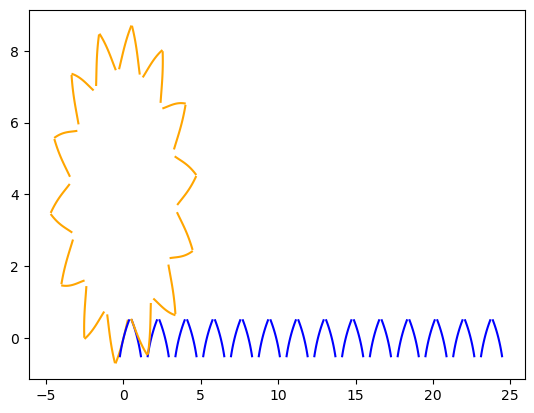

In [85]:
toothCt2 = 14

Gear2 = [complex() for _ in range(toothCt2*2)]
Gear2[0] = data_Gear2['z']
Gear2[1] = mirrorZ(data_Gear2['z'], np.pi*3/2 - np.pi/(toothCt2*2), centerPt= Radius2*1j)
for i in range(len(Gear2) - 2):
    Gear2[i + 2] = rotateZ(Gear2[i], -2*np.pi/toothCt2, centerPt= 1j * Radius2)

GearR = [complex() for _ in range(toothCt2*2)]
GearR[0] = [complex(data_Gear2['x'][i], data_Gear2['y'][i]) for i in range(res)]
GearR[1] = mirrorZ(GearR[0], np.pi/2, complex(np.pi/(toothCt2*2) * Radius2,0))
for i in range(len(Gear2) - 2):
    GearR[i+2] = [g + 2*np.pi/(toothCt2) * Radius2 for g in GearR[i]]

for i in range(len(Gear2)):
    plt.plot(np.real(Gear2[i]), np.imag(Gear2[i]), 'orange')
    plt.plot(np.real(GearR[i]), np.imag(GearR[i]), 'blue')

In [86]:
fig, ax = plt.subplots()

# Melting into a single column for simplicity of plotting
Gear2f = [complex() for _ in range(res * toothCt2 * 2)]
GearRf = [complex() for _ in range(res * toothCt2 * 2)] 
for i in range(toothCt2 * 2):
    for j in range(res):
        if np.mod(i, 2) == 0:
            Gear2f[i * res + j] = Gear2[i][res-1 - j]
            GearRf[i * res + j] = GearR[i][j]
        else:
            Gear2f[i * res + j] = Gear2[i][j]
            GearRf[i * res + j] = GearR[i][res-1 - j]

MatingGear_plt = ax.plot(np.real(Gear2f), np.imag(Gear2f), 'orange')[0]
Rack_plt = ax.plot(np.real(GearRf), np.imag(GearRf), 'blue')[0]

frames = res * 4
def update(frame):
    if frame <= frames/2:
        MatingGear_curr = rotateZ(Gear2f, -np.pi*2/frames * frame, Radius2 * 1j)
        Rack_plt.set_xdata(np.real(GearRf) - (np.pi*2/frames * frame * Radius2))
    else: 
        MatingGear_curr = rotateZ(Gear2f, -np.pi*2/frames * (frames - frame), Radius2 * 1j)
        Rack_plt.set_xdata(np.real(GearRf) - (np.pi*2/frames * (frames - frame) * Radius2))
    MatingGear_plt.set_xdata(np.real(MatingGear_curr))
    MatingGear_plt.set_ydata(np.imag(MatingGear_curr))

    return (MatingGear_plt, Rack_plt)

ax.set_aspect('equal')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ani = anim.FuncAnimation(fig = fig, func = update, frames = frames, interval = .5)
if reload_Gifs:
    ani.save("assets/RackAndGearFull.gif", writer = "pillow")
plt.close()
HTML('<img src="./assets/RackAndGearFull.gif">')

### Creating the Drive Gear

Converting the Driving Rack into a Driving Gear

The formulation of a Drive Gear is very straightforward with the rack and profile curve already defined. It is the exact same process as before, but this time in reference to a gear formed by cutting to the 'inside' of the rack profile, rather than the 'outside' as used by the mating gear. 

In application, it is simply flipping the sign of the $x$ and $x_p$ values for the equivalent $y$ values in the mating gear.

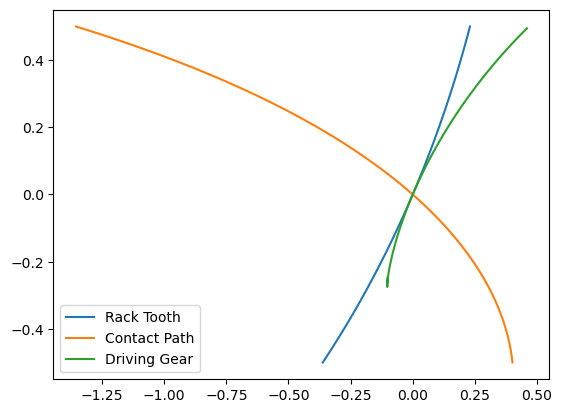

In [87]:
Radius1 = 4

# Flip the values
data_Gear1 = data_Gear2[["y"]].map(lambda y: -y)
data_Gear1 = data_Gear1.join(data_Gear2[["x"]].map(lambda x: -x))
data_Gear1 = data_Gear1.join(data_Gear2[["x_p"]].map(lambda xp: -xp))

# Solving
d = {}
for var in ['r', 'eps', 'theta']:
    d[var] = np.zeros(len(data_Gear1['y']))
d['z'] = [complex() for _ in range(len(data_Gear1[['y']]))]

for i in range(len(data_Gear1['y'])):
    vals = {y:data_Gear1['y'][i],
            x:data_Gear1['x'][i],
            xp:data_Gear1['x_p'][i],
            R: Radius1}
    d["r"][i], vals[r] = (Eqs[r].subs(vals), )*2
    d["eps"][i], vals[eps] =  (Eqs[eps].subs(vals), )*2
    d["theta"][i], vals[theta] = (Eqs[theta].subs(vals), )*2

    d["z"][i] = complex(vals[r] * np.exp(1j * (float(vals[theta]) + np.pi*1/2)) - Radius1*1j)

data_Gear1 = data_Gear1.join(pd.DataFrame(d))

plt.plot(data_Gear1['x'], data_Gear1['y'], label = "Rack Tooth")
plt.plot(data_Gear1['x_p'], data_Gear1['y'], label = "Contact Path")
plt.plot(np.real(data_Gear1['z']), np.imag(data_Gear1['z']), label = "Driving Gear")
plt.legend()

Note here the cusp of the Driving profile on the left side; this would need trimmed away to create a functional gear. For now, it will be ignored.

In [88]:
minTooth1 = np.ceil(2 * np.pi / (max(data_Gear1["eps"]) - min(data_Gear1["eps"])))
display("Minimum Number of Teeth for Continuous Engagement: %s" % (minTooth1))
maxTooth1 = np.floor(np.pi / (max(data_Gear1["theta"] - min(data_Gear1["theta"]))))
display("Maximum Number of Teeth before Intersection of Profiles: %s" % (maxTooth1))


'Minimum Number of Teeth for Continuous Engagement: 11.0'

'Maximum Number of Teeth before Intersection of Profiles: 24.0'

In [89]:
toothCt1 = 14
display('Circular Pitch: Gear1 =  %s | Gear2 = %s' % (2*np.pi* Radius1/toothCt1, 2*np.pi*Radius2/toothCt2))
display('Equivalent Diametral Pitch: Gear1 = %s | Gear2 = %s' % (Radius1*2/toothCt1, Radius2*2/toothCt2))
display('Equivalent Module: Gear1 = %s | Gear2 = %s' % (toothCt1/Radius1/2, toothCt2/Radius2/2))

# Defining the Basis Gear Geometry
Gear1 = [complex() for _ in range(toothCt1*2)]
Gear1[0] = data_Gear1['z']
Gear1[1] = mirrorZ(data_Gear1['z'], np.pi*1/2 + np.pi/(toothCt1*2), centerPt= -Radius1*1j)
for i in range(len(Gear1) - 2):
    Gear1[i + 2] = rotateZ(Gear1[i], 2*np.pi/toothCt1, centerPt= 1j * -Radius1)

# Melting the Gear 1 data into a single column
Gear1f = [complex() for _ in range(res *toothCt1 *2)]
for i in range(toothCt1*2):
    for j in range(res):
        if np.mod(i, 2) == 0:
            Gear1f[i * res + j] = Gear1[i][res-1 -j]
        else:
            Gear1f[i * res + j] = Gear1[i][j]

fig, ax = plt.subplots()

MatingGear_plt = ax.plot(np.real(Gear2f), np.imag(Gear2f))[0]
DrivingGear_plt = ax.plot(np.real(Gear1f), np.imag(Gear1f))[0]
Contact_plt = ax.plot(-data_Gear2['x_p'], data_Gear2['y'])[0]

## Contact Point dances around the teeth rather than following the path ~ no backlash in teeth.
#ContactPt_index = np.argmin([np.abs(np.subtract(Gear1[0][i], Gear2[0][i])) for i in range(len(Gear1[0]))])
#ContactPt = Gear1[0][ContactPt_index]
#ContactPt_plt = ax.plot(np.real(ContactPt), np.imag(ContactPt), 'ro', label = "Contact Point")[0]

frames = res*2
def update(frame):
    #Gear1t1_curr = rotateZ(Gear1[0], -np.pi/frames * frame, Radius2 * 1j)
    #Gear2t1_curr = rotateZ(Gear2[0], -np.pi/frames * frame, Radius2 * 1j)

    MatingGear_curr = rotateZ(Gear2f, -np.pi/frames * frame, Radius2 * 1j)
    DrivingGear_curr = rotateZ(Gear1f, np.pi/frames * frame * toothCt2/toothCt1, Radius1 * -1j)

    #ContactPt_index = np.argmin([np.abs(np.subtract(Gear1t1_curr[i], Gear2t1_curr[i])) for i in range(len(Gear2t1_curr))])
    #ContactPt = Gear1t1_curr[ContactPt_index]

    MatingGear_plt.set_xdata(np.real(MatingGear_curr))
    MatingGear_plt.set_ydata(np.imag(MatingGear_curr))
    DrivingGear_plt.set_xdata(np.real(DrivingGear_curr))
    DrivingGear_plt.set_ydata(np.imag(DrivingGear_curr))
    
    #ContactPt_plt.set_xdata([np.real(ContactPt)])
    #ContactPt_plt.set_ydata([np.imag(ContactPt)]) 

    return (MatingGear_plt, DrivingGear_plt, Contact_plt)#, ContactPt_plt)

ax.set_aspect('equal')
ani = anim.FuncAnimation(fig = fig, func = update, frames = frames, interval = .5)
if reload_Gifs:
    ani.save("assets/GearAndGearFull.gif", writer = 'pillow')
plt.close()
HTML('<img src="./assets/GearAndGearFull.gif">')

'Circular Pitch: Gear1 =  1.7951958020513104 | Gear2 = 1.7951958020513104'

'Equivalent Diametral Pitch: Gear1 = 0.5714285714285714 | Gear2 = 0.5714285714285714'

'Equivalent Module: Gear1 = 1.75 | Gear2 = 1.75'

In [40]:
fig, ax = plt.subplots()

MatingGear_plt = ax.plot(np.real(Gear2f), np.imag(Gear2f))[0]
DrivingGear_plt = ax.plot(np.real(Gear1f), np.imag(Gear1f))[0]
Contact_plt = ax.plot(-data_Gear2['x_p'], data_Gear2['y'])[0]
ax.set_aspect('equal')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ani = anim.FuncAnimation(fig = fig, func = update, frames = frames, interval = .5)
if reload_Gifs:
    ani.save("assets/GearAndGearFull_zoom.gif", writer = 'pillow')
plt.close()
HTML('<img src="./assets/GearAndGearFull_zoom.gif">')


Keep in mind that the Pitch of the gears must be equal for proper meshing:

In [41]:
Radius1 = 4
toothCt1 = 17
display('Module: Gear1 = %s | Gear2 = %s' % (toothCt1/Radius1/2, toothCt2/Radius2/2))

fig, ax = plt.subplots()

data_Gear1 = data_Gear2[["y"]].map(lambda y: -y)
data_Gear1 = data_Gear1.join(data_Gear2[["x"]].map(lambda x: -x))
data_Gear1 = data_Gear1.join(data_Gear2[["x_p"]].map(lambda xp: -xp))

d = {}
for var in ['r', 'eps', 'theta']:
    d[var] = np.zeros(len(data_Gear1['y']))
d['z'] = [complex() for _ in range(len(data_Gear1[['y']]))]

for i in range(len(data_Gear1['y'])):
    vals = {y:data_Gear1['y'][i],
            x:data_Gear1['x'][i],
            xp:data_Gear1['x_p'][i],
            R: Radius1}
    d["r"][i], vals[r] = (Eqs[r].subs(vals), )*2
    d["eps"][i], vals[eps] =  (Eqs[eps].subs(vals), )*2
    d["theta"][i], vals[theta] = (Eqs[theta].subs(vals), )*2

    d["z"][i] = complex(vals[r] * np.exp(1j * (float(vals[theta]) + np.pi*1/2)) - Radius1*1j)

data_Gear1 = data_Gear1.join(pd.DataFrame(d))

Gear1 = [complex() for _ in range(toothCt1*2)]
Gear1[0] = data_Gear1['z']
Gear1[1] = mirrorZ(data_Gear1['z'], np.pi*1/2 + np.pi/(toothCt1*2), centerPt= -Radius1*1j)
for i in range(len(Gear1) - 2):
    Gear1[i + 2] = rotateZ(Gear1[i], 2*np.pi/toothCt1, centerPt= 1j * -Radius1)

Gear1f = [complex() for _ in range(res *toothCt1 *2)]
for i in range(toothCt1*2):
    for j in range(res):
        if np.mod(i, 2) == 0:
            Gear1f[i * res + j] = Gear1[i][res-1 -j]
        else:
            Gear1f[i * res + j] = Gear1[i][j]

MatingGear_plt = ax.plot(np.real(Gear2f), np.imag(Gear2f))[0]
DrivingGear_plt = ax.plot(np.real(Gear1f), np.imag(Gear1f))[0]
Contact_plt = ax.plot(data_Gear2['x_p'], data_Gear2['y'])[0]

frames = res*3
def update(frame):
    MatingGear_curr = rotateZ(Gear2f, -np.pi/frames * frame, Radius2 * 1j)
    DrivingGear_curr = rotateZ(Gear1f, np.pi/frames * frame * toothCt2/toothCt1, Radius1 * -1j)

    MatingGear_plt.set_xdata(np.real(MatingGear_curr))
    MatingGear_plt.set_ydata(np.imag(MatingGear_curr))
    DrivingGear_plt.set_xdata(np.real(DrivingGear_curr))
    DrivingGear_plt.set_ydata(np.imag(DrivingGear_curr))

    return (MatingGear_plt, DrivingGear_plt, Contact_plt)

ax.set_aspect('equal')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ani = anim.FuncAnimation(fig = fig, func = update, frames = frames, interval = .5)
if reload_Gifs:
    ani.save("assets/GearAndGearFull_DifferentModules_zoom.gif", writer = 'pillow')
plt.close()
HTML('<img src="./assets/GearAndGearFull_DifferentModules_zoom.gif">')


'Module: Gear1 = 2.125 | Gear2 = 1.75'

Clearly, that is not working as intended. The proportions of the gears must be kept in agreement for proper meshing; see below.

 **Note as well**, the forms for these gears are __fully dependent__ on the given input radii; it is common knowledge that cycloidal/involute gear forms are able to mesh indepedent of base diameter, but this is __NOT__ true for general conjugate action.

In [42]:
Radius1 = 8
toothCt1 = int(1.75 * Radius1 * 2)
display('Module: Gear1 = %s | Gear2 = %s' % (toothCt1/Radius1/2, toothCt2/Radius2/2))

fig, ax = plt.subplots()

data_Gear1 = data_Gear2[["y"]].map(lambda y: -y)
data_Gear1 = data_Gear1.join(data_Gear2[["x"]].map(lambda x: -x))
data_Gear1 = data_Gear1.join(data_Gear2[["x_p"]].map(lambda xp: -xp))

d = {}
for var in ['r', 'eps', 'theta']:
    d[var] = np.zeros(len(data_Gear1['y']))
d['z'] = [complex() for _ in range(len(data_Gear1[['y']]))]

for i in range(len(data_Gear1['y'])):
    vals = {y:data_Gear1['y'][i],
            x:data_Gear1['x'][i],
            xp:data_Gear1['x_p'][i],
            R: Radius1}
    d["r"][i], vals[r] = (Eqs[r].subs(vals), )*2
    d["eps"][i], vals[eps] =  (Eqs[eps].subs(vals), )*2
    d["theta"][i], vals[theta] = (Eqs[theta].subs(vals), )*2

    d["z"][i] = complex(vals[r] * np.exp(1j * (float(vals[theta]) + np.pi*1/2)) - Radius1*1j)

data_Gear1 = data_Gear1.join(pd.DataFrame(d))

Gear1 = [complex() for _ in range(toothCt1*2)]
Gear1[0] = data_Gear1['z']
Gear1[1] = mirrorZ(data_Gear1['z'], np.pi*1/2 + np.pi/(toothCt1*2), centerPt= -Radius1*1j)
for i in range(len(Gear1) - 2):
    Gear1[i + 2] = rotateZ(Gear1[i], 2*np.pi/toothCt1, centerPt= 1j * -Radius1)

Gear1f = [complex() for _ in range(res *toothCt1 *2)]
for i in range(toothCt1*2):
    for j in range(res):
        if np.mod(i, 2) == 0:
            Gear1f[i * res + j] = Gear1[i][res-1 -j]
        else:
            Gear1f[i * res + j] = Gear1[i][j]

MatingGear_plt = ax.plot(np.real(Gear2f), np.imag(Gear2f))[0]
DrivingGear_plt = ax.plot(np.real(Gear1f), np.imag(Gear1f))[0]
#Contact_plt = ax.plot(-data_Gear2['x_p'], data_Gear2['y'])[0]

frames = res*3
def update(frame):
    MatingGear_curr = rotateZ(Gear2f, -2*np.pi/frames * frame, Radius2 * 1j)
    DrivingGear_curr = rotateZ(Gear1f, 2*np.pi/frames * frame * toothCt2/toothCt1, Radius1 * -1j)

    MatingGear_plt.set_xdata(np.real(MatingGear_curr))
    MatingGear_plt.set_ydata(np.imag(MatingGear_curr))
    DrivingGear_plt.set_xdata(np.real(DrivingGear_curr))
    DrivingGear_plt.set_ydata(np.imag(DrivingGear_curr))

    return (MatingGear_plt, DrivingGear_plt) #, Contact_plt)

ax.set_aspect('equal')
ani = anim.FuncAnimation(fig = fig, func = update, frames = frames, interval = .5)
if reload_Gifs:
    ani.save("assets/GearAndGearFull_SameModules.gif", writer = 'pillow')
plt.close()

HTML('<img src="./assets/GearAndGearFull_SameModules.gif">')


'Module: Gear1 = 1.75 | Gear2 = 1.75'

In [43]:
# Storing particular rack formulas for later:
x, y, xp, phi = s.symbols("x y x_p \\phi")
eps, theta, r, R = s.symbols("\\epsilon \\theta r R")

Eqs = {}
Eqs[xp] = -1 * y / s.tan(phi)
Eqs[r] = s.sqrt( (R - y)**2 + xp**2 )
Eqs[eps] = (xp - x)/R
Eqs[theta] = s.atan(xp / (R - y)) - Eqs[eps]

Eqset = {"RackMate": Eqs}
display(Eqset)

Eqs = {}

{'RackMate': {x_p: -y/tan(\phi),
  r: sqrt(x_p**2 + (R - y)**2),
  \epsilon: (-x + x_p)/R,
  \theta: atan(x_p/(R - y)) - (-x + x_p)/R}}

## Next: Gear Tooth Defined